In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prepare Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import trefide.preprocess as preprocess
import scipy.io as io

Simulations run using a cohort 37 real neural signals extracted from a Q-State Bio Voltage Imaging Video (sampled at 1000Hz) as atoms to construct "artificial" signals of arbitrary length. An important assumption is that all neural signals are detrended and centered, so we use a robust B-spline regression informed by the timing of optogenetic stimuli to precisely cut out any slow trends.

In [3]:
# Load Data
stim = io.loadmat("../data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("../data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [4]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [5]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

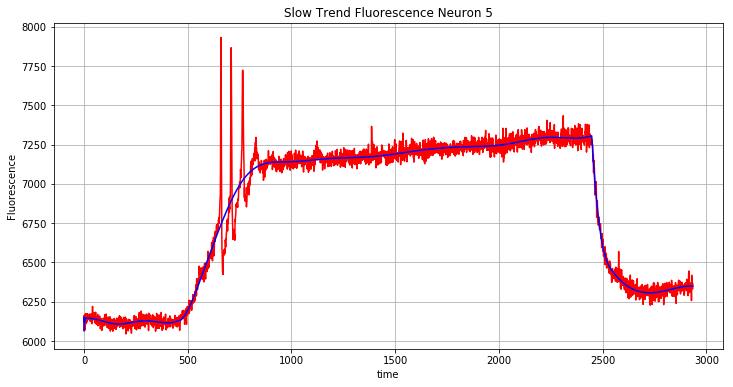

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Compare Solve Times Over Range of Problem Sizes

In [7]:
from trefide.solvers.temporal import cpdas, lpdas, ipm
from trefide.utils import psd_noise_estimate
from timeit import timeit

## Run Simulations

In [8]:
sizeData = np.arange(1,10) * T
ipm_times = np.zeros((len(signals), len(sizeData)))
lpdas_times = np.zeros((len(signals), len(sizeData)))
cpdas_times = np.zeros((len(signals), len(sizeData)))
lpdas_ws_times = np.zeros((len(signals), len(sizeData)))
cpdas_ws_times = np.zeros((len(signals), len(sizeData)))
for sdx, signal in enumerate(signals):
    for ndx in np.arange(1,len(sizeData)+1):
        target = np.tile(signal, ndx)
        delta = psd_noise_estimate(target[None,:])[0]
        _, _, lam, _ = cpdas(target, delta)
        # Interior Point Method
        def time_ipm():
            _, _, _ = ipm(target, lam)
        ipm_times[sdx, ndx-1] += timeit(time_ipm, number=3)/3
        # Langrangian Primal-Dual Active Set Method
        def time_lpdas():
            _, _, _ = lpdas(target, lam)
        lpdas_times[sdx, ndx-1] += timeit(time_lpdas, number=3)/3
        # Constrianed Primal-Dual Active Set Method
        def time_cpdas():
            _, _, _, _ = cpdas(target, delta)
        cpdas_times[sdx, ndx-1] += timeit(time_cpdas, number=3)/3
        # Warm-Started Langrangian Primal-Dual Active Set Method
        _, l_warm_start, _ = lpdas(target, lam*1.1)
        def time_ws_lpdas():
            _, _, _ = lpdas(target, lam, z_hat=l_warm_start)
        lpdas_ws_times[sdx, ndx-1] = timeit(time_ws_lpdas, number=1)/1
        # Warm Started Constrained Primal-Dual Active Set Method
        _, c_warm_start, _ = lpdas(target, lam*1.1)
        def time_ws_cpdas():
            _, _, _, _ = cpdas(target, delta, z_hat=c_warm_start, lambda_=lam*1.1)
        cpdas_ws_times[sdx, ndx-1] = timeit(time_ws_cpdas, number=1)/1

## Use Average Solve Times & Errorbars To Guage Efficiency

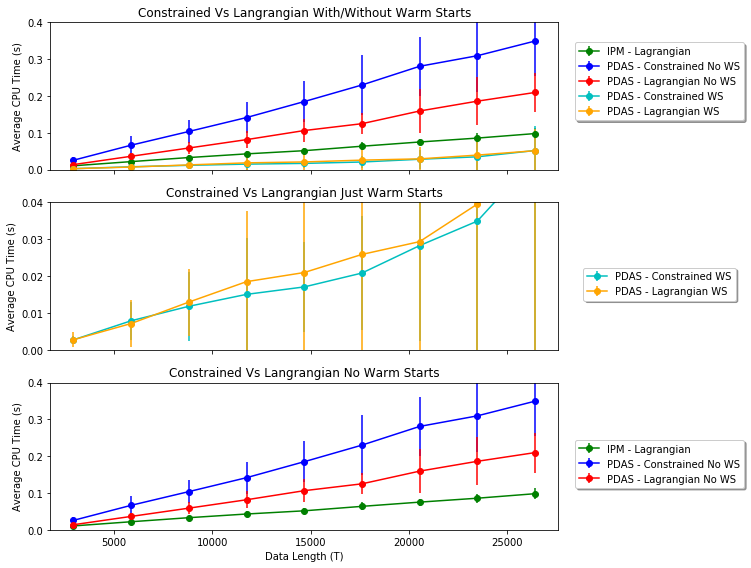

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,8), sharex=False)

ax = axs[0]
ax.errorbar(sizeData, np.mean(ipm_times, axis=0), yerr=np.std(ipm_times, axis=0), marker='o', c='g')
ax.errorbar(sizeData, np.mean(cpdas_times, axis=0), yerr=np.std(cpdas_times, axis=0), marker='o', c='b')
ax.errorbar(sizeData, np.mean(lpdas_times, axis=0), yerr=np.std(lpdas_times, axis=0), marker='o', c='r')
ax.errorbar(sizeData, np.mean(cpdas_ws_times, axis=0), yerr=np.std(cpdas_ws_times, axis=0), marker='o', c='c')
ax.errorbar(sizeData, np.mean(lpdas_ws_times, axis=0), yerr=np.std(lpdas_ws_times, axis=0), marker='o', c='orange')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('Constrained Vs Langrangian With/Without Warm Starts')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['IPM - Lagrangian',
           'PDAS - Constrained No WS',
           'PDAS - Lagrangian No WS',
           'PDAS - Constrained WS',
           'PDAS - Lagrangian WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[1]
ax.errorbar(sizeData, np.mean(cpdas_ws_times, axis=0), yerr=np.std(cpdas_ws_times, axis=0), marker='o', c='c')
ax.errorbar(sizeData, np.mean(lpdas_ws_times, axis=0), yerr=np.std(lpdas_ws_times, axis=0), marker='o', c='orange')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.04))
ax.set_title('Constrained Vs Langrangian Just Warm Starts')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['PDAS - Constrained WS',
           'PDAS - Lagrangian WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[2]
ax.errorbar(sizeData, np.mean(ipm_times, axis=0), yerr=np.std(ipm_times, axis=0), marker='o', c='g')
ax.errorbar(sizeData, np.mean(cpdas_times, axis=0), yerr=np.std(cpdas_times, axis=0), marker='o', c='b')
ax.errorbar(sizeData, np.mean(lpdas_times, axis=0), yerr=np.std(lpdas_times, axis=0), marker='o', c='r')
ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('Constrained Vs Langrangian No Warm Starts')
ax.locator_params(nbins=6)

ax.legend(['IPM - Lagrangian',
           'PDAS - Constrained No WS',
           'PDAS - Lagrangian No WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .25),
          ncol=1,
          fancybox=True,
          shadow=True)

fig.tight_layout()
plt.show()

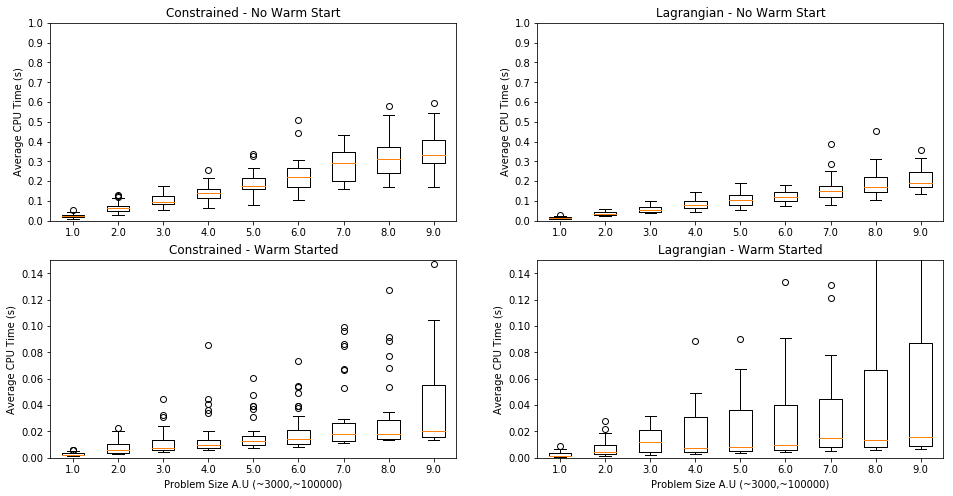

In [10]:
# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8), sharex=False)
ax = axs[0,0]
ax.boxplot(cpdas_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Constrained - No Warm Start')

ax = axs[0,1]
ax.boxplot(lpdas_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Lagrangian - No Warm Start')

ax = axs[1,0]
ax.boxplot(cpdas_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.15))
ax.set_title('Constrained - Warm Started')

ax = axs[1,1]
ax.boxplot(lpdas_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.15))
ax.set_title('Lagrangian - Warm Started')


#fig.tight_layout()
plt.show()

## Use Boxplots To Identify Convergence Issues &/or Line Search Failures

## Record System Information

Sources compiled against single-threaded MKL libraries without multithreading.

In [11]:
!uname -a

Linux ubuntu-tower 4.10.0-42-generic #46~16.04.1-Ubuntu SMP Mon Dec 4 15:57:59 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux


In [12]:
!cpuinfo

Intel(R) processor family information utility, Version 2018 Update 2 Build 20180125 (id: 18157)
Copyright (C) 2005-2018 Intel Corporation.  All rights reserved.

=====  Processor composition  =====
Processor name    : Intel(R) Xeon(R)  E5-2620 v4 
Packages(sockets) : 1
Cores             : 8
Processors(CPUs)  : 16
Cores per package : 8
Threads per core  : 2

=====  Processor identification  =====
Processor	Thread Id.	Core Id.	Package Id.
0       	0   		0   		0   
1       	0   		1   		0   
2       	0   		2   		0   
3       	0   		3   		0   
4       	0   		4   		0   
5       	0   		5   		0   
6       	0   		6   		0   
7       	0   		7   		0   
8       	1   		0   		0   
9       	1   		1   		0   
10      	1   		2   		0   
11      	1   		3   		0   
12      	1   		4   		0   
13      	1   		5   		0   
14      	1   		6   		0   
15      	1   		7   		0   
=====  Placement on packages  =====
Package Id.	Core Id.	Processors
0   		0,1,2,3,4,5,6,7		(0,8)(1,9)(2,10)(3,11)(4,12)(5,13)(6,14)(7,15)

====

# Save Previous Results For Comparison
### Update cells below and leave unmodified while making any solver updates

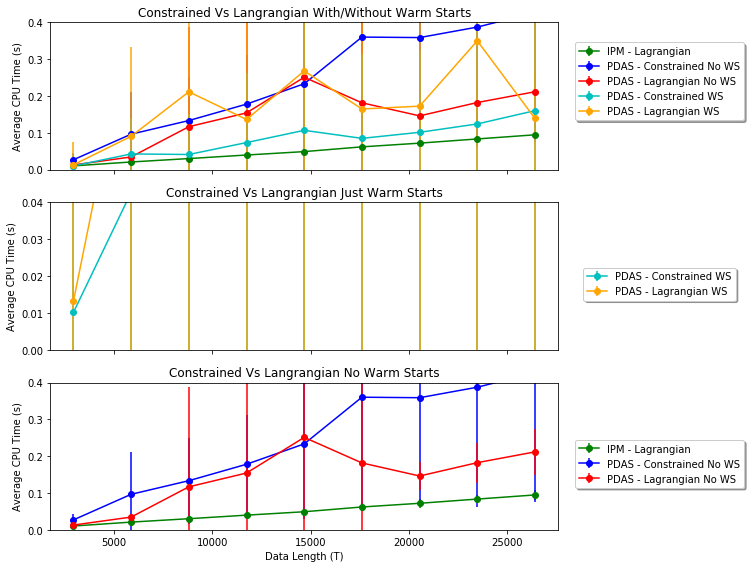

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,8), sharex=False)

ax = axs[0]
ax.errorbar(sizeData, np.mean(ipm_times, axis=0), yerr=np.std(ipm_times, axis=0), marker='o', c='g')
ax.errorbar(sizeData, np.mean(cpdas_times, axis=0), yerr=np.std(cpdas_times, axis=0), marker='o', c='b')
ax.errorbar(sizeData, np.mean(lpdas_times, axis=0), yerr=np.std(lpdas_times, axis=0), marker='o', c='r')
ax.errorbar(sizeData, np.mean(cpdas_ws_times, axis=0), yerr=np.std(cpdas_ws_times, axis=0), marker='o', c='c')
ax.errorbar(sizeData, np.mean(lpdas_ws_times, axis=0), yerr=np.std(lpdas_ws_times, axis=0), marker='o', c='orange')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('Constrained Vs Langrangian With/Without Warm Starts')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['IPM - Lagrangian',
           'PDAS - Constrained No WS',
           'PDAS - Lagrangian No WS',
           'PDAS - Constrained WS',
           'PDAS - Lagrangian WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[1]
ax.errorbar(sizeData, np.mean(cpdas_ws_times, axis=0), yerr=np.std(cpdas_ws_times, axis=0), marker='o', c='c')
ax.errorbar(sizeData, np.mean(lpdas_ws_times, axis=0), yerr=np.std(lpdas_ws_times, axis=0), marker='o', c='orange')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.04))
ax.set_title('Constrained Vs Langrangian Just Warm Starts')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['PDAS - Constrained WS',
           'PDAS - Lagrangian WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[2]
ax.errorbar(sizeData, np.mean(ipm_times, axis=0), yerr=np.std(ipm_times, axis=0), marker='o', c='g')
ax.errorbar(sizeData, np.mean(cpdas_times, axis=0), yerr=np.std(cpdas_times, axis=0), marker='o', c='b')
ax.errorbar(sizeData, np.mean(lpdas_times, axis=0), yerr=np.std(lpdas_times, axis=0), marker='o', c='r')
ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.4))
ax.set_title('Constrained Vs Langrangian No Warm Starts')
ax.locator_params(nbins=6)

ax.legend(['IPM - Lagrangian',
           'PDAS - Constrained No WS',
           'PDAS - Lagrangian No WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .25),
          ncol=1,
          fancybox=True,
          shadow=True)

fig.tight_layout()
plt.show()

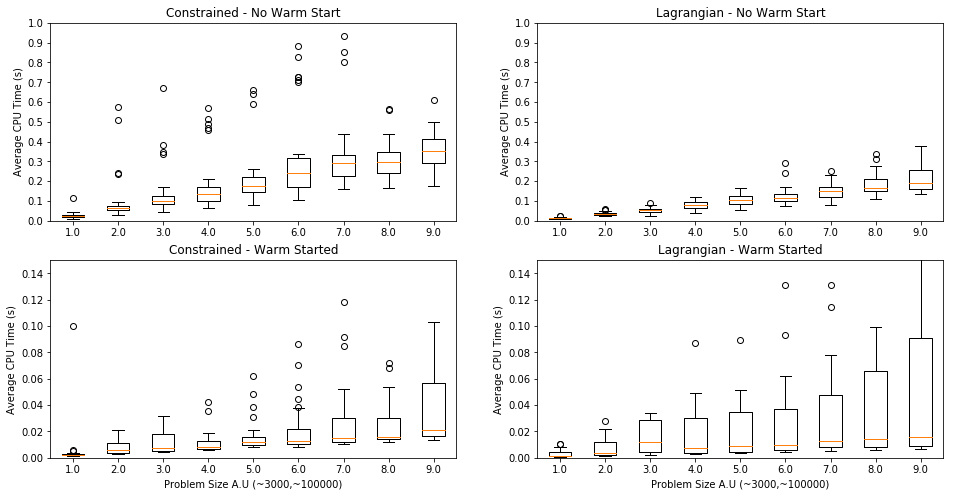

In [14]:
# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,8), sharex=False)
ax = axs[0,0]
ax.boxplot(cpdas_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Constrained - No Warm Start')

ax = axs[0,1]
ax.boxplot(lpdas_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Lagrangian - No Warm Start')

ax = axs[1,0]
ax.boxplot(cpdas_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.15))
ax.set_title('Constrained - Warm Started')

ax = axs[1,1]
ax.boxplot(lpdas_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.15))
ax.set_title('Lagrangian - Warm Started')


#fig.tight_layout()
plt.show()

In [15]:
!uname -a

Linux ubuntu-tower 4.10.0-42-generic #46~16.04.1-Ubuntu SMP Mon Dec 4 15:57:59 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux


In [12]:
!cpuinfo

Intel(R) processor family information utility, Version 2018 Update 2 Build 20180125 (id: 18157)
Copyright (C) 2005-2018 Intel Corporation.  All rights reserved.

=====  Processor composition  =====
Processor name    : Intel(R) Xeon(R)  E5-2620 v4 
Packages(sockets) : 1
Cores             : 8
Processors(CPUs)  : 16
Cores per package : 8
Threads per core  : 2

=====  Processor identification  =====
Processor	Thread Id.	Core Id.	Package Id.
0       	0   		0   		0   
1       	0   		1   		0   
2       	0   		2   		0   
3       	0   		3   		0   
4       	0   		4   		0   
5       	0   		5   		0   
6       	0   		6   		0   
7       	0   		7   		0   
8       	1   		0   		0   
9       	1   		1   		0   
10      	1   		2   		0   
11      	1   		3   		0   
12      	1   		4   		0   
13      	1   		5   		0   
14      	1   		6   		0   
15      	1   		7   		0   
=====  Placement on packages  =====
Package Id.	Core Id.	Processors
0   		0,1,2,3,4,5,6,7		(0,8)(1,9)(2,10)(3,11)(4,12)(5,13)(6,14)(7,15)

====